In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import torch.nn.functional as F
import torch

from common import metrics

In [19]:
from typing import Tuple
from torch import Tensor
import numpy as np
import torch
import torch.nn.functional as F


@torch.no_grad()
def fill_tolerance(labels: Tensor, tolerance: int) -> Tensor:
    ws = (1, 1, 2 * tolerance + 1)
    ones = torch.ones(ws, dtype=labels.dtype, device=labels.device)
    full = F.conv1d(labels.unsqueeze(1), ones, padding="same")
    full = (full.squeeze(1) > 0).to(labels.dtype)
    return full


def errors_curve(
    y_score: Tensor, y_true: Tensor, tolerance: int, num_thrs: int = 100
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    y_true_full = fill_tolerance(y_true, tolerance)

    mn, mx = y_score.min(), y_score.max()
    step = (mx - mn) / num_thrs
    thrs = np.arange(mn, mx, step)

    fps = []
    fns = []
    for th in thrs:
        preds: Tensor = (y_score > th).to(y_true.dtype)
        preds_full = fill_tolerance(preds, tolerance)
        fps.append(((1 - y_true_full) * preds).sum().item())
        fns.append((y_true * (1 - preds_full)).sum().item())

    fps = np.asarray(fps)
    fns = np.asarray(fns)

    return fps, fns, thrs

In [20]:
bs = 128
wl = 1024
winsize = 12
signals = torch.rand(bs, wl)
gt_labels = (torch.rand_like(signals) > 0.7).to(torch.int)

n_t = 100


def cm_win():
    fp, fn, th = metrics.errors_curve(signals, gt_labels, winsize, n_t)
    metrics.plot_errors_curve(fp, fn, th)

def cm_win_2():
    fp, fn, th = errors_curve(signals, gt_labels, winsize, n_t)
    metrics.plot_errors_curve(fp, fn, th)

In [21]:
%%timeit
fp, fn, th = metrics.errors_curve(signals, gt_labels, winsize, n_t)

700 ms ± 66.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%%timeit
fp, fn, th = errors_curve(signals, gt_labels, winsize, n_t)

510 ms ± 16.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


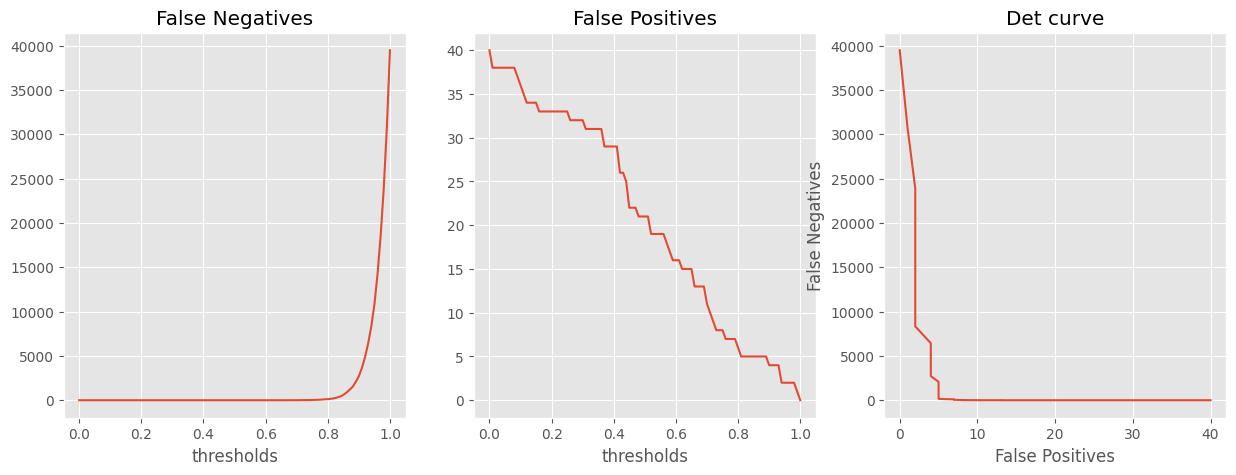

In [23]:
cm_win()

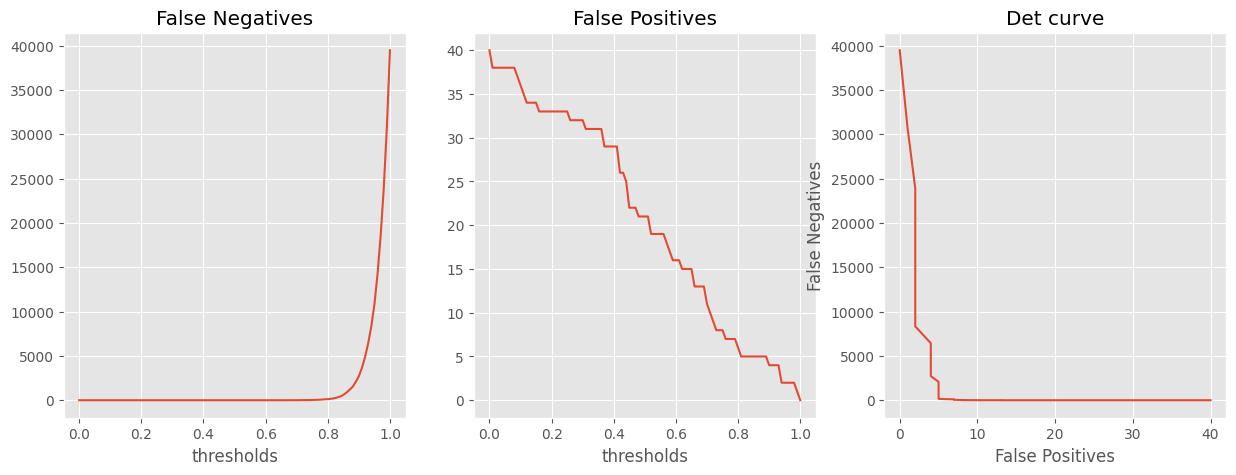

In [24]:
cm_win_2()